<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/05_MakeMoreShort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore-05


**WaveNet-Inspired Model in PyTorch**

In this notebook, we extend the 2-layer MLP from before into a deeper, tree-structured model inspired by **WaveNet (2016)**. While we don't yet use dilated convolutions, we mimic the hierarchical architecture to capture longer context.

**Key Objectives:**

* Refactor code using `torch.nn` modules and containers
* Learn the practicalities of model building in PyTorch (e.g. shape tracking, debugging, batch normalization issues)
* Implement and train a deeper model with `block_size=8`

**Steps Covered:**

* Code cleanup and learning rate visualization
* Modularizing the model using `torch.nn`
* Building and training a WaveNet-like deep architecture
* Fixing a `BatchNorm1d` bug and re-training
* Scaling the model and evaluating its performance
* Laying the groundwork for **dilated causal convolutions** (not yet implemented)

**Focus:**
Understanding PyTorch's model building blocks and the real-world development loop—iteration, experimentation, and debugging.



# Initialize Dataset

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all words
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt
words = open('names.txt').read().splitlines()
words[:8]

--2025-06-04 14:50:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-06-04 14:50:05 (6.04 MB/s) - ‘names.txt’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Generate Dataset - using Splits

In [ ]:
# built dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


# Generate Dataset - using Splits

In [ ]:
# built dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> e
..e ---> b
.eb ---> r
ebr ---> i
bri ---> m
rim ---> a
ima ---> .
... ---> h
..h ---> i
.hi ---> l
hil ---> t
ilt ---> o
lto ---> n
ton ---> .
... ---> j
..j ---> h
.jh ---> e
jhe ---> n
hen ---> e
ene ---> .


# Improving our Representation/ Model Structure


- every Layer gets a Module
- the Model is represented by initilizing a Sequential Module
- mean over every 100 losses for better representation
- forward pass gets much simpler
- in initilization when setting the weights for initialization we now call
```
model.layers[-1],weight *= 0.1
```

## Improved Layer Representation (Make every Layer a Module) + Setting Hyperparameters

In [ ]:
# basically the same as in course 3
# -----------------------------------------------------------------------------------

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------

class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


## Improved Initilization

Now we have a Model as initialized as a Sequential Modlule

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# now our layer are getting a model wich is a modul
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


## Improved Forward Pass

Now we do not list every layer for the forward pass but call
```
logits = model(Xb)
```

Also for better representation of the loss we calculate a mean over every 100 losses

```
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1).detach().numpy())
```

In [ ]:
# same optimiuzation as last time

max_steps = 200 #0000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

  # forward pass
  x = Xb
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracks stats
  if i%10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/    200: 3.3315


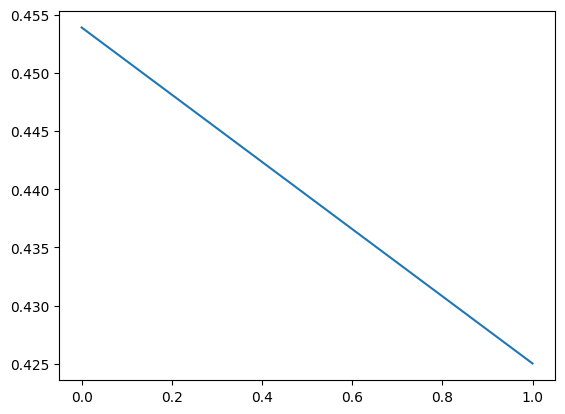

In [ ]:

plt.plot(torch.tensor(lossi).view(-1, 100).mean(1).detach().numpy())

## Improved Evaluation

Don't forget for evaluating to  put all layers in not Training mode:
```
for layer in model.layers:
  layer.training = False
```

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
      'train': {Xtr, Ytr},
      'val': {Xdev, Ydev},
      'test': {Xte, Yte},
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.611018180847168
test 2.617330312728882


## Improved Sampling

In [ ]:
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample form the distribution
    ix = torch.multinomial(probs, num_samples = 1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

iaoain.
batxlaxzematalon.
yyl.
bagei.
mdye.
aser.
avkiun.
ppkjrztanggiarh.
zoa.
myr.
fgan.
kezca.
phon.
fiaqsoana.
dospazaila.
brie.
yi.
uabe.
slaisanjha.
qvh.


#

# Building a Wavenet - Dialated Causal Convolutional Layers/ Implementing a Hierarchical Scheme - Changing block_size


## Evaluate

How a WaveNet works:

- Start by combining two characters into a bigram.

- Then, combine two bigrams into a larger unit.

- Repeat this hierarchical fusion to build increasingly abstract representations.

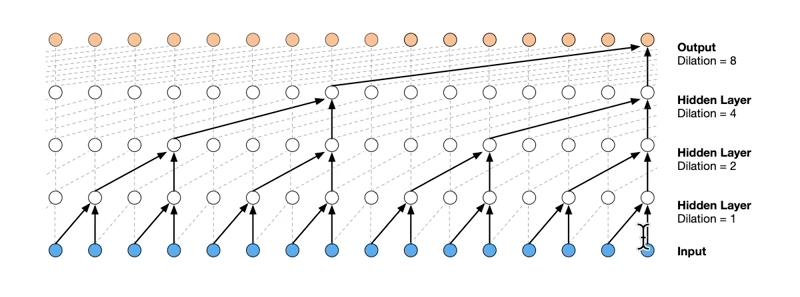

## Initilize Datasets - improved (now 8 character for each block)

In [ ]:
# built dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> t
.......t ---> a
......ta ---> u
.....tau ---> r
....taur ---> e
...taure ---> n
..tauren ---> .
........ ---> s
.......s ---> u
......su ---> l
.....sul ---> e
....sule ---> m
...sulem ---> a
..sulema ---> n
.suleman ---> .
........ ---> z
.......z ---> e
......ze ---> r
.....zer ---> e
....zere ---> n


## Initialize Modules

In [ ]:
# basically the same as in course 3
# -----------------------------------------------------------------------------------

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------

class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


## Update on Flatten Module

### Going deeper direction Batch Dimensions

#### On initilization - Flatten is not working the way we want it to

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

# now our layer are getting a model wich is a modul
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

7273


#### Handlling Dimensions with Pytorch

We can easily reshape the input dimensions to group characters into bigrams and pass them to the layers.


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch: 1 dim, 4 examples
Xb, Yb = Xtr[ix], Ytr[ix] # Xb: (4,8), Yb: (4,0)
logits = model(Xb)
Xb

tensor([[ 0,  0,  0,  0,  0,  1, 12,  1],
        [ 0,  0,  0,  0,  0, 12,  5,  9],
        [ 0,  0,  3,  1, 20,  1, 12,  5],
        [14, 14,  1, 12,  5,  9, 19,  5]])

There are this many zeros because, when encoding a name, we always start with a block of 8 zeros and then slide the window forward through the name.

#### View the shape of every layer

In [ ]:
print('output Embedding Layer: ',model.layers[0].out.shape)
print('output Flatten Layer: ',model.layers[1].out.shape)
print('output Linear Layer: ',model.layers[2].out.shape)


output Embedding Layer:  torch.Size([4, 8, 10])
output Flatten Layer:  torch.Size([4, 80])
output Linear Layer:  torch.Size([4, 64])


#### Get a feeling how Matrix Multiplication operand @ works

...starting with an basic example

In [ ]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

If there are more than two dimensions (e.g., shape (4, 5, 80)), the @ operator performs matrix multiplication on the last two dimensions for each batch.

In [ ]:
(torch.randn(4,5,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [ ]:
(torch.randn(2,3,4,4,5,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([2, 3, 4, 4, 5, 200])

#### Matrix Multiplication in the Context of Batch Dimensions

In the following example we calculate 16 vectors in parallel

In [ ]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

shape (4,4,20) means:
  - 4 samples
  - 4 positions
  - 20 dimensional embedding

...means that we process 16 20-dimensional vectors in parallel

More Examples of how to work with Dimensions in Pytorch

In [ ]:
e = torch.randint(0, 10,(4,8,10))
#e = torch.randn(4,8,10)

e_2 = e[:, ::2, :]
e_12 = e[:, 1::2, :]
explicit = torch.cat([e_2, e_12], dim = 2)

In [ ]:
#print(e)
#print(explicit)
(e.view(4,4,20) == explicit).all()

tensor(True)

In [ ]:
e.view(e.shape[0], -1).shape

torch.Size([4, 80])

#### New FlattenConsecutive Module

before:
```
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []
```

In [ ]:
class FlattenConsecutive: # there is also a Flatten Pytorch Module but they are nor equal

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) # squeezes out all dimension that are one; (A x 1 X B x 1 x C) -> (A x B x 1 x C)

    self.out = x
    return self.out

  def parameters(self):
    return []

## Initialization - Updated Linear Layer/ FlattenConsecutive Initilization

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

# now our layer are getting a model wich is a modul
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Layer 1
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 2
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 3
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


#### Here we need one forward pass, else we can't inspect layer.out

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

# forward pass
x = Xb
logits = model(Xb)
loss = F.cross_entropy(logits, Yb) # loss function

# backward pass
for p in parameters:
  p.grad = None
loss.backward()


#### Now compare the new Initialization with the shapes of every layer

We made changes in:
- FlattenConsecutive
  - now we define the dimension that is flattend
- also the Linear Layer
  - must adapt to the 2*input


In [ ]:
for layer in model.layers[2:]:
  print(layer.__class__.__name__, ': ', tuple(layer.out.shape))

Linear :  (32, 4, 68)
BatchNorm1d :  (32, 4, 68)
FlattenConsecutive :  (32, 2, 136)
Linear :  (32, 2, 68)
BatchNorm1d :  (32, 2, 68)
FlattenConsecutive :  (32, 136)
Linear :  (32, 68)
BatchNorm1d :  (32, 68)
Tanh :  (32, 68)
Linear :  (32, 27)


## Forward Pass

In [ ]:
# same optimiuzation as last time

max_steps = 200 #200000
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

  # forward pass
  x = Xb
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracks stats
  if i%10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/  20000: 3.2875


## Evaluate

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
      'train': {Xtr, Ytr},
      'val': {Xdev, Ydev},
      'test': {Xte, Yte},
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 3.289177656173706
test 3.2891087532043457


Performance Log

- Original (3-char context, 200 hidden neurons, 12K params): train 2.058, val 2.105
- Context increased 3 → 8 (22K params): train 1.918, val 2.027
- Flat → hierarchical (22K params): train 1.941, val 2.029

So far, switching to hierarchical evaluation hasn’t improved performance.
There might be a bug in our Batch Normalization layer.










## Sample form the Model

In [ ]:
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample form the distribution
    ix = torch.multinomial(probs, num_samples = 1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

gimlm.
ztzhiaoxzlkloqsdlqzkdbr.
aabsfztkypeizfooklnhiyffansgpegkxtlbkksgdxsycxyxcpqtsyscpcuaynbzjyqvclhxr.
zhhndzmlhlozryt.
qgqjikoo.
fglidkjow.
bifch.
gkdhmbqaahbszbdktyzmjxrfynieos.
ugcvwgpahlwxpgpbmzwimesyczogutehelfcgqyuhohhwyiyqwlqpapavlsdivsfiw.
kdlxrzfwjjrkorunyntwfljwhiypihhgnmpsfgyrnzqx.
iugayomoqmnnkdmjpxmvwjnmyqtryvmwjlmzamzlt.
by.
jegnezivetiffapantfeszxklv.
clbzdswvqqknhmhbbqkorcdcnpvilauqzsrshypesegeraasdvrttjcxbflxpxbqyceyepekak.
lyfnmp.
zpymjrhduqbooznrubhapoojhmtfvtlzhpnfaofxnwslzfdsafiyvxrkdaidmcwvsxfciulbpkohllnhjjuwkagoabwnahrhytwvwxnzmyfbptaadjvqaqtzpodrcyqdinvyzduub.
dae.
yedtylfiqfqbdjljhrflroiighnrmwbd.
jydwffcaejussrvxonwtyejrpwlgdnovmcdrovjbja.
kakikmkzfhxmurbuhztwdbgciuvdusc.


# Fixing BatchNorm

Look at the way we implemented Batch Normalization
-> in the call() method we calculate mean and var over th 0th dimension, but we would need it to be the 2st last dimension

```
class BatchNorm1d:

# ...
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
  ...
```

In [ ]:
# what we are doing in code

e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
emean.shape
evar.shape

torch.Size([1, 4, 68])

In [ ]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

According to the [torch.mean() documentation](https://docs.pytorch.org/docs/stable/generated/torch.mean.html), you can pass either an integer or a tuple of integers to specify the dimension(s) to reduce.

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) # 1, 1, 68
evar = e.var((0,1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
print(emean.shape)
print(evar.shape)
print(ehat.shape)

torch.Size([1, 1, 68])
torch.Size([1, 1, 68])
torch.Size([32, 4, 68])


## Updated BatchNorm

In [ ]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass


    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

## Note that we are getting away from official Pytorch here

- Checking the input/output shapes in the BatchNorm1d docs:

- Input: (N, C) or (N, C, L)

  - N = batch size

  - C = number of features

  - L = sequence length

- For (N, C, L), normalization reduces over dimensions 0 and 2.

- PyTorch assumes C is the second dimension, but in our case, C is the last dimension, and we may have multiple batch dimensions before it.

What we actually expect:
Input shape like (N, C) or (N, L, C) instead.

# Now let's pump up the Model (Hyperparameters) and Evaluate

## Hyperparameters

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# now our layer are getting a model wich is a modul
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Layer 1
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 2
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 3
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


## Training

In [ ]:
# same optimiuzation as last time

max_steps = 200 #00000
# max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

  # forward pass
  x = Xb
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracks stats
  if i%10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/    200: 3.2393


## Evaluation

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
      'train': {Xtr, Ytr},
      'val': {Xdev, Ydev},
      'test': {Xte, Yte},
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.4741735458374023
test 2.479973554611206


**performance log**
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierachical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train: 1.912, val: 2.022
- scale up the network: n_embd = 24, n_hidden = 128 (76K params): train 1.769, val 1.993

## Sample from the model

In [ ]:
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample form the distribution
    ix = torch.multinomial(probs, num_samples = 1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

aesyan.
mrieanw.
ebratsj.
aamanny.
aarien.
kdetta.
sylan.
meslana.
iimanlaele.
aaylinn.
yemen.
tuahele.
larae.
aolany.
zmbren.
eeeagee.
arken.
jeimi.
aeyras.
acrce.


## Disadvantage with bigger Model

- experiments start longer to train
- so we are missing a sort of an experimental harness on which we could run a number of experiments
- then we could tune this architecture very well

# What we got so far

* We're continuously decreasing loss on both train and validation sets.
* However, our current approach is mostly guess-and-check — which isn’t ideal.
* The process becomes more meaningful when we start extracting real insights from the numbers.
* One key thing we haven’t implemented yet is the more advanced forward pass described in the WaveNet paper, which includes:

  * Gated linear units
  * Residual connections
  * Skip connections


## How what we did relates to convolutional neural networks

* We use convolutions purely for efficiency — they don’t change the model’s logic.
* Example: for the name *diondre*

  * Previously, we used a Python for-loop to generate 8 inputs (from `........` to `.diondre`), computing logits one by one.
  * With convolutional networks, this process runs in parallel within CUDA kernels — the for-loop is effectively hidden inside the convolution.


## Convolutions

* A for-loop applying a small linear filter over an input sequence is conceptually what a convolution does.
* In our case, the input space is one-dimensional, and we slide these filters over the input to extract features.


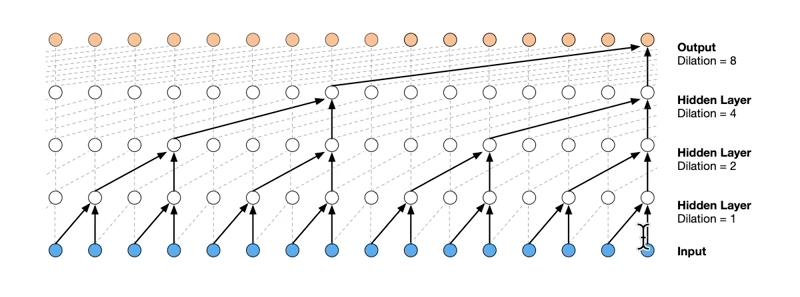

When comparing our work to the image:

* What we’ve done so far is represented by the black arrow tree — using several input samples to compute one output.
* Convolution allows us to slide this structure (blue dots) across the input and compute all outputs (yellow dots) simultaneously.

In our case:

```
........  --> d  
.......d  --> i  
......di  --> o  
.....dio  --> n  
....dion  --> d  
...diond  --> r  
..diondr  --> e  
.diondre  --> .  
```

This means we can compute all input-output pairs for *diondre* in parallel.


With convolutions, the CUDA kernel can reuse computed data.
In a for-loop, each input passes through the layers independently — requiring fresh computation at every step.
But with convolutions, the first hidden layer (with dilation = 1) is computed once, and its outputs are shared across all filter windows that need them.



**Convolutions in Neural Networks — In a Nutshell:**

* Use **filters** (small linear layers)
* Slide these filters over the input sequence
* Compute each layer fully before moving to the next

  * Data is shared across all operations within the same layer
* This makes the process **highly efficient**


## Something about the model structure we use

this is how we now create the flow of our model:

```
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Layer 1
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 2
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    # Layer 3
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])
```

...we now use kind of Lego building blocks/ Modul building blocks



What we also implemented is a sort of container for model: 'Sequential' and pytorchified our code a bit more.

How it works in praxis: we use Torch.NN on top of Torch.Tensor

## What we learned about the developing process of Building DNNs

1. We spend a lot of time in the documentation of pytorch - looking through all the layers/ reading documentation. What are the shapes of the inputs/ what can they be/ What does the layer do...
- but you need to know:
  - the documentation is bad
    - they lie to you
    - things will be wrong/ incomplete
    - it will be unclear
2. Thers is a ton of trying to make the shapes work and there's a lot gymnastics around these multi-dimensional arrays (1 dim, 2 dim, ...)
- is it NCL or NLC
3. Youn can prototype layers (as we did) in notebooks and make sure that all the shapes work out
- you take a lot of time babysitting the shapes (is everything correct?)
- when saticfied with functionality of Colab Notebook then take the code and copy paste it in a repository
- then in next step (or on the side) use VS Code
4. This lecture unlocks a lot of potential for further lectures
- we can convert our network to use 'dialated causal convolutional layers'
- what are redidual connections and for what are they usefull?
- right now we have no experimental harness
  - normaly we would need to setup your evaluation harness
  - you kick of experiments
  - you have a lot of arguments that your script can take
  - you look a lot on plots of training and validation losses
    - what is working/ what is not working
    - what is working on a specific population level
    - you do hyperpayrameter searches
5. We should cover Recurring Neural Networks, RNs, Lstm's, Grooves, Transormers


# Interesting exercise on this Colab

Goal: Beat validation loss of 1.993

Tuning options:
- n_embd (embedding dimension)
- Try a simpler network (e.g., single-layer) to outperform the hierarchical model
- Read the WaveNet paper to understand and implement relevant layer structures
- Tune initialization:
  - Initial weights of the final layer
  - batch_size